In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_excel('premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [3]:
df.shape

(50000, 13)

In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [5]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


### Handling Null Values

In [6]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [7]:
df.dropna(inplace=True) # We remove the null values because, compared to 50000 values 13,11 are small
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
int(df.duplicated().sum())

0

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Statistics of Numerical Columns

In [10]:
df[df.number_of_dependants < 0].shape

(72, 13)

In [11]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1])

#### After brainstorming with data engineer team , they said it was a positive value assigned as a negative 

In [12]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [13]:
numerical_columns = df.select_dtypes(['float64', 'int64']).columns
numerical_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

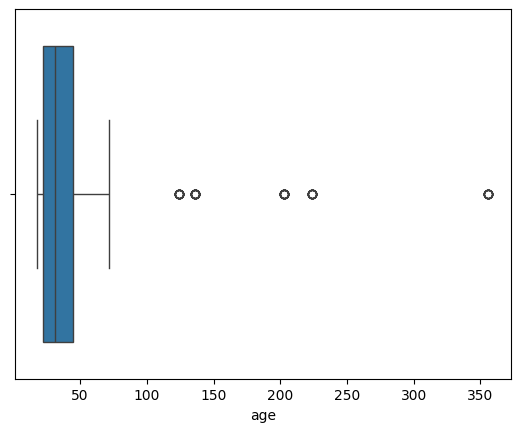

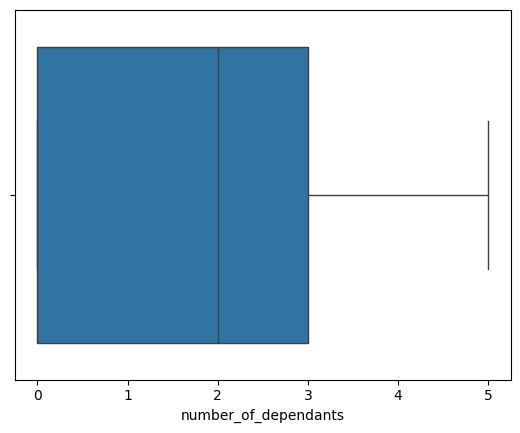

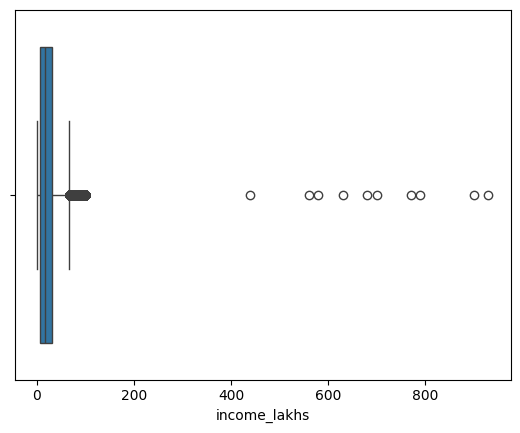

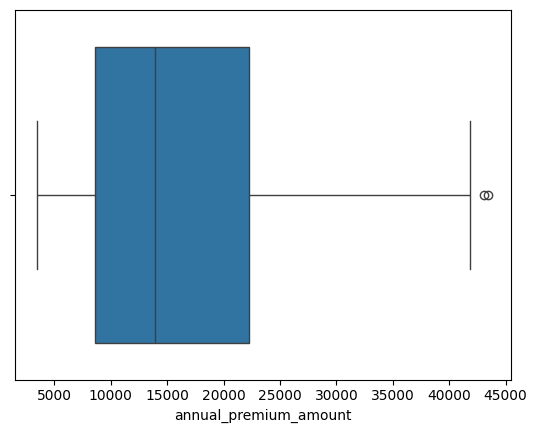

In [14]:
for col in numerical_columns:
    sns.boxplot(x = df[col])
    plt.show()

In [15]:
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356])

In [16]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [17]:
def get_boundaries(col):
    Q1, Q3 = df1[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return lower, upper

In [18]:
get_boundaries('income_lakhs')

(-29.0, 67.0)

#### Ignore the lower boundary, and use the domain knowledge .(67 Lakhs) is not a big amount in India. Instead of IQR, we use this

In [19]:
threshold = int(df1['income_lakhs'].quantile(0.999))
threshold

100

In [20]:
df1[df1['income_lakhs']>100].shape

(10, 13)

In [21]:
df2 = df1[df1['income_lakhs']<=100].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


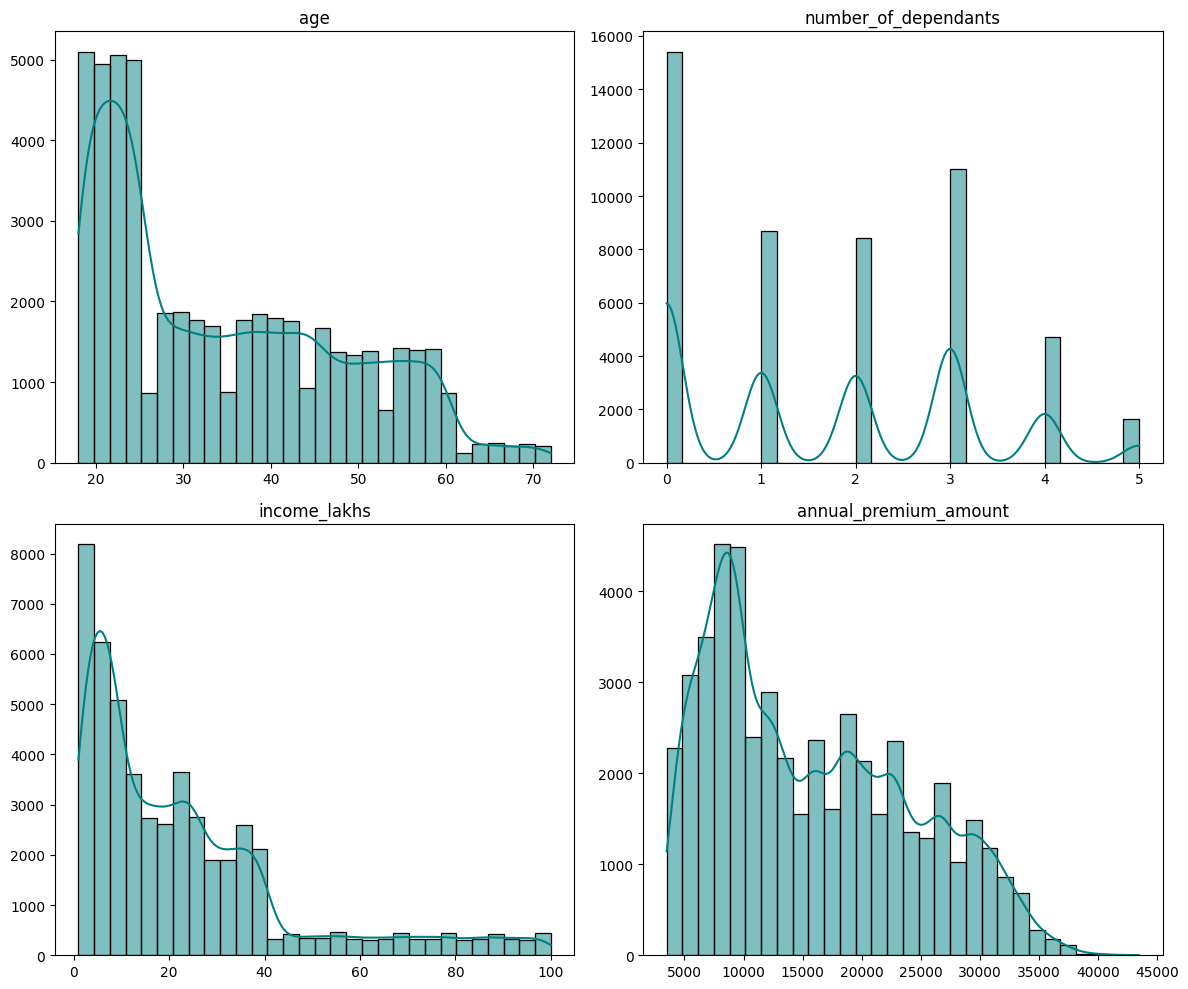

In [22]:
selected_cols = numerical_columns[:4]  # Adjust as needed

plt.figure(figsize=(12, 10))

for i, col in enumerate(selected_cols, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    sns.histplot(df2[col], kde=True, color='teal', bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()                      #Univariate Analysis

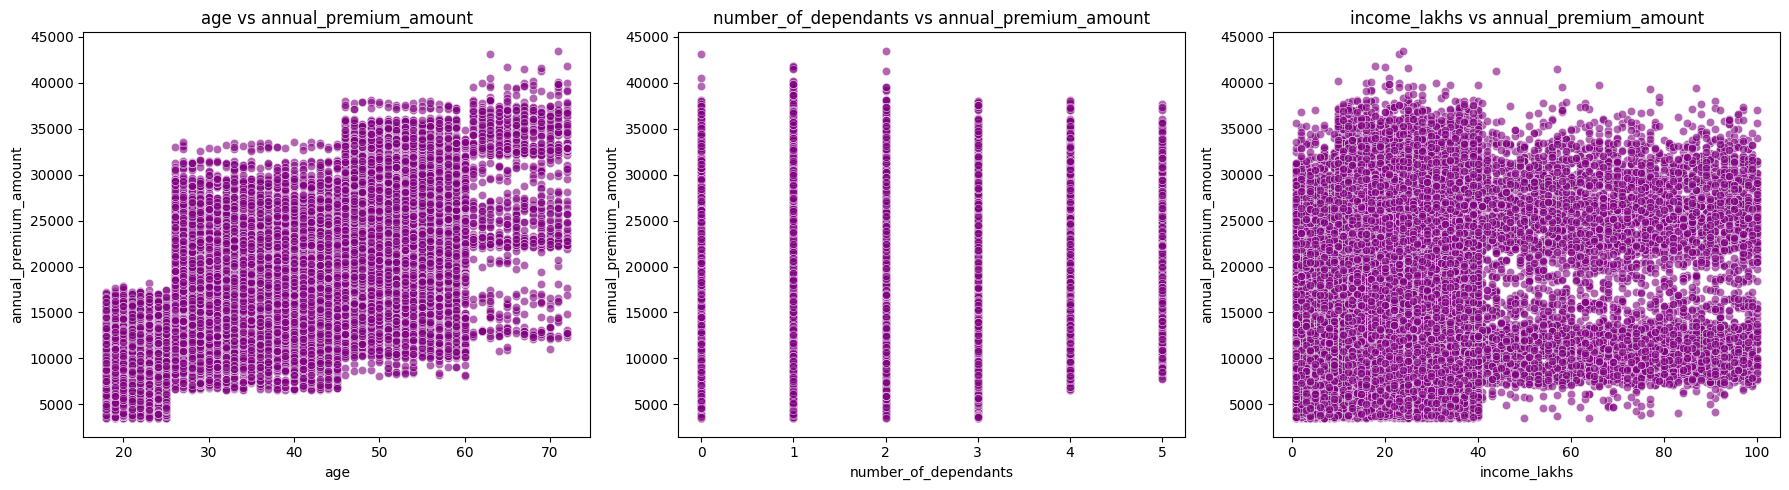

In [23]:
numerical_features = ['age', 'number_of_dependants', 'income_lakhs']
target = 'annual_premium_amount'

plt.figure(figsize=(18, 5))  # Wide layout for side-by-side plots

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns
    sns.scatterplot(data=df2, x=feature, y=target, color='purple', alpha=0.6)
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()                              #Bivariate Analysis

### Let's move to Categorical values

In [24]:
categorical_columns = df2.select_dtypes(include=['object', 'string']).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [25]:
for cat in categorical_columns:
    print(cat,' :',df2[cat].unique())

gender  : ['Male' 'Female']
region  : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status  : ['Unmarried' 'Married']
bmi_category  : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status  : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status  : ['Salaried' 'Self-Employed' 'Freelancer']
income_level  : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history  : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan  : ['Bronze' 'Silver' 'Gold']


In [26]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace = True)
df2.smoking_status.unique()

C:\Users\RAKESH KAPILAVAI\AppData\Local\Temp\ipykernel_12200\1456019954.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [27]:
#Univariate Analysis

In [28]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

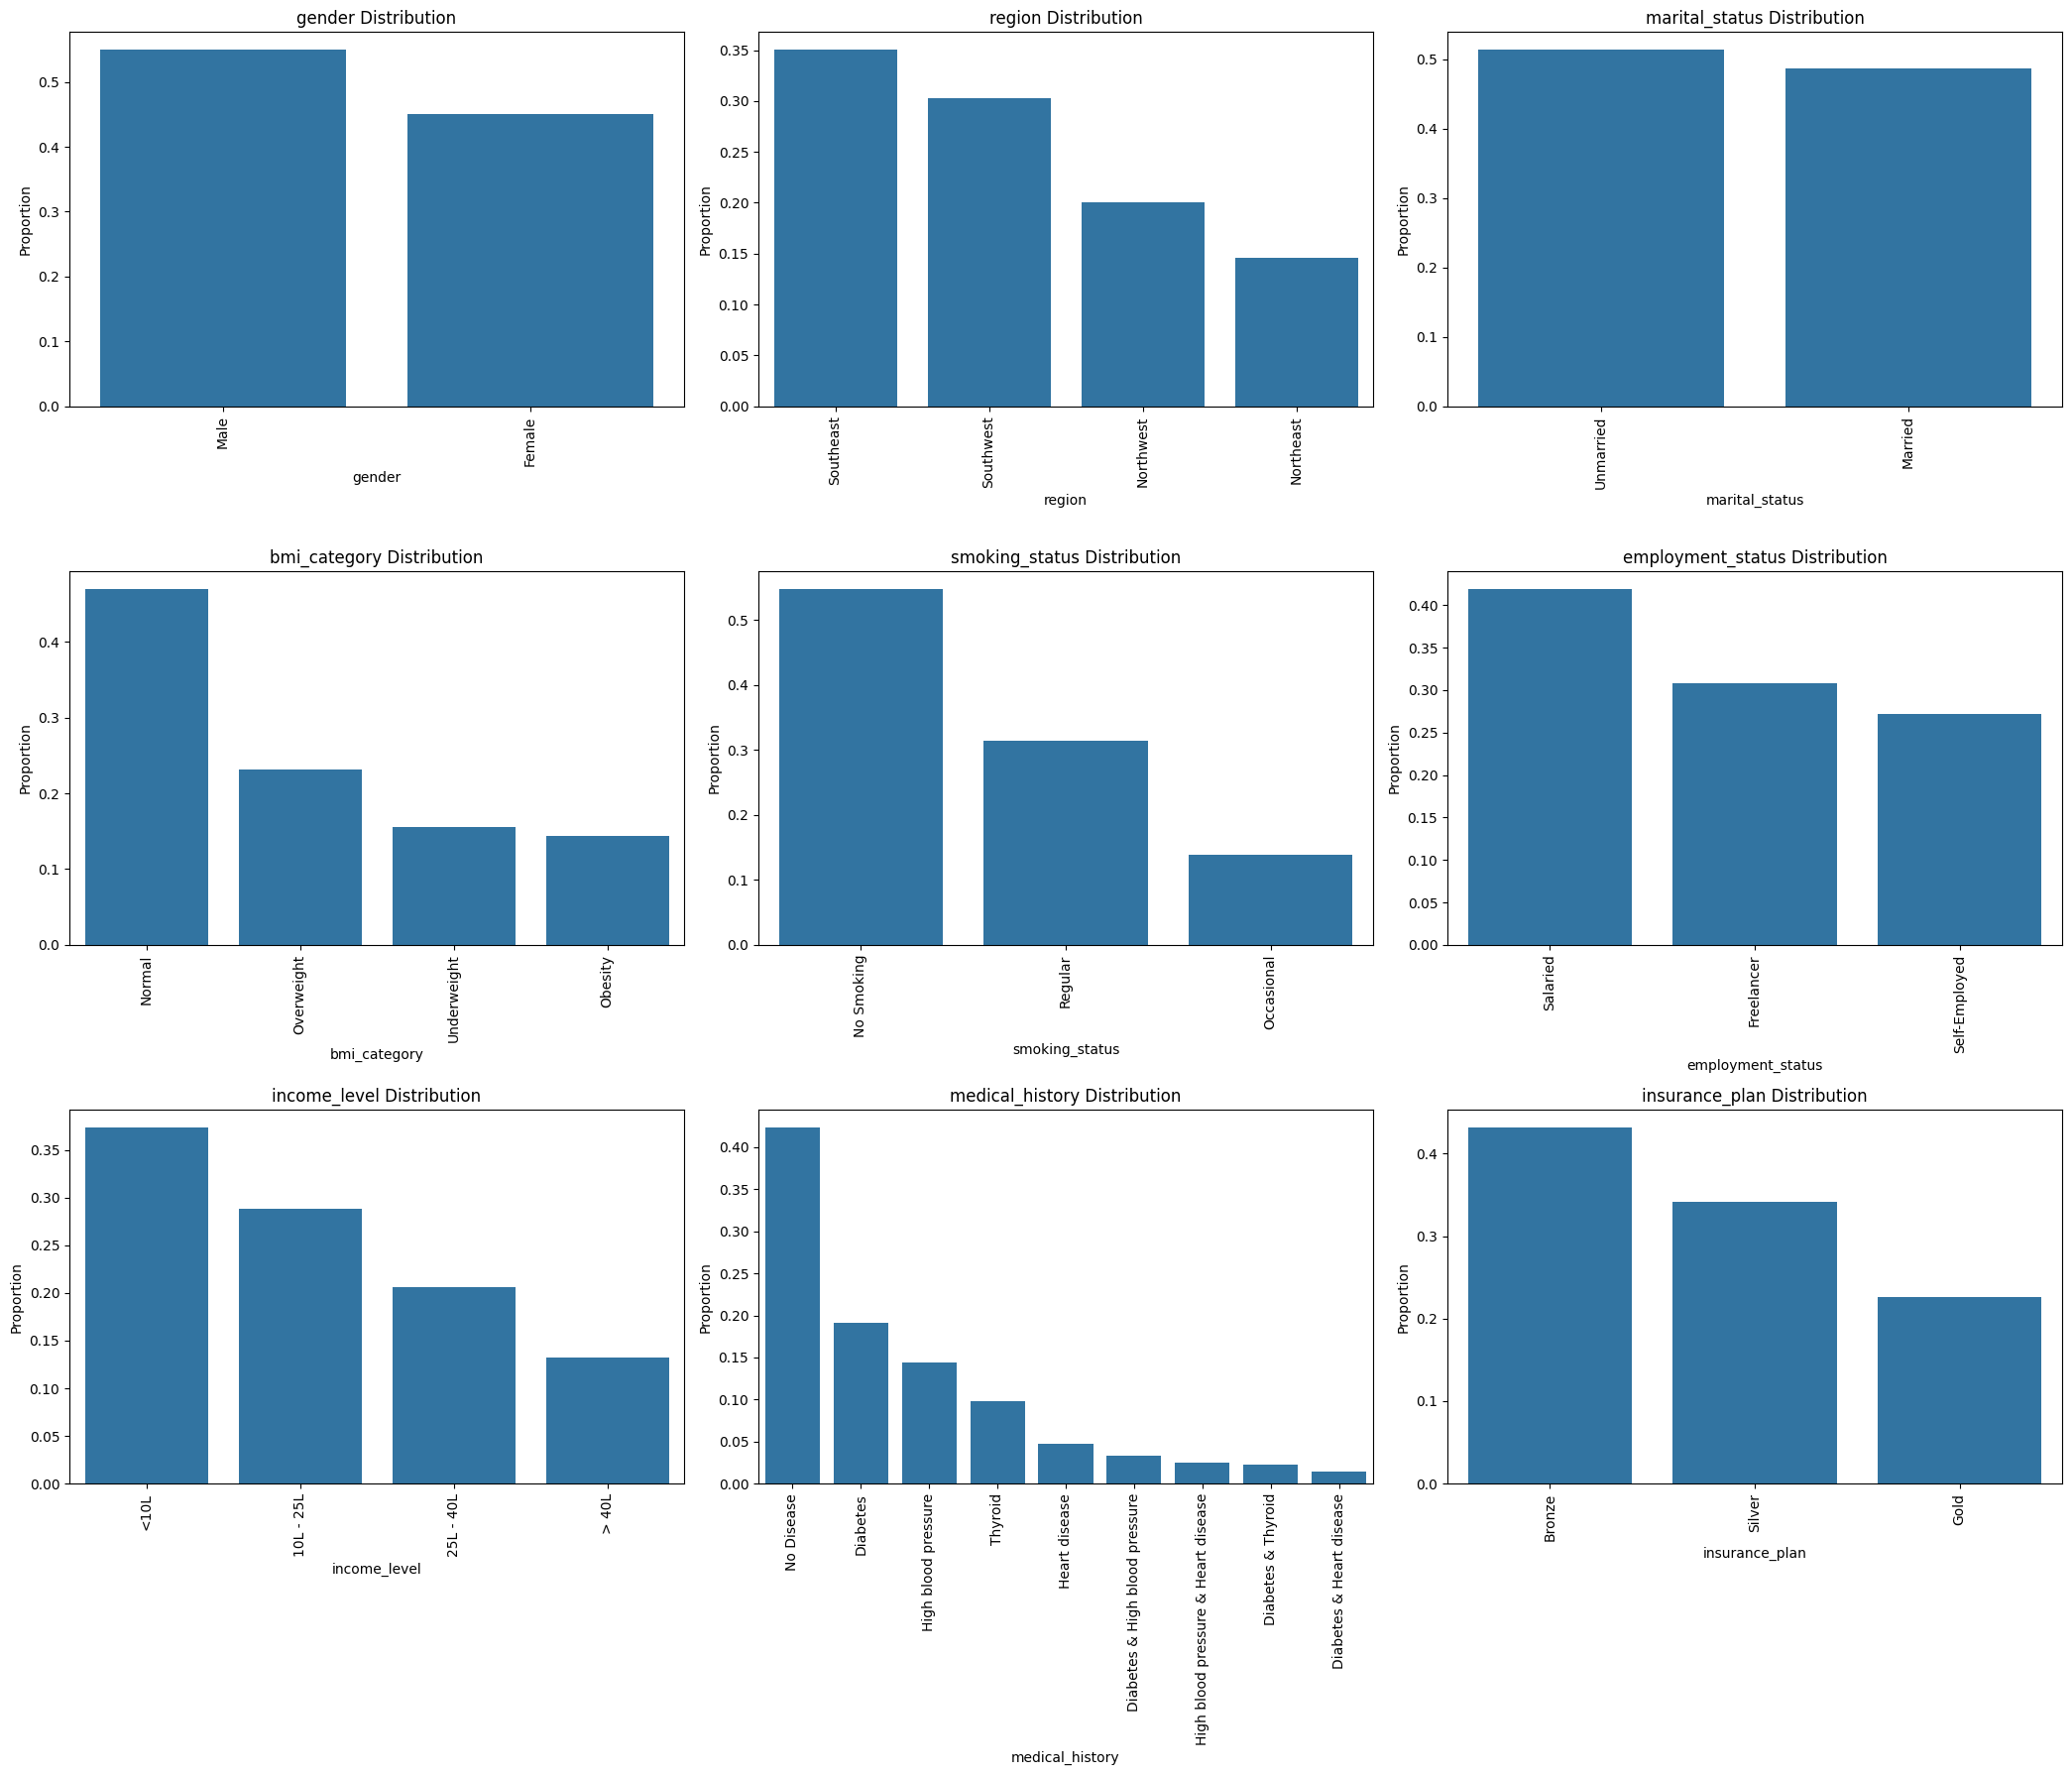

In [29]:
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols
plt.figure(figsize=(7 * n_cols, 6 * n_rows))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Calculate percentage distribution
    pct_count = df2[col].value_counts(normalize=True)
    
    # Plot
    sns.barplot(x=pct_count.index, y=pct_count.values)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [30]:
#Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


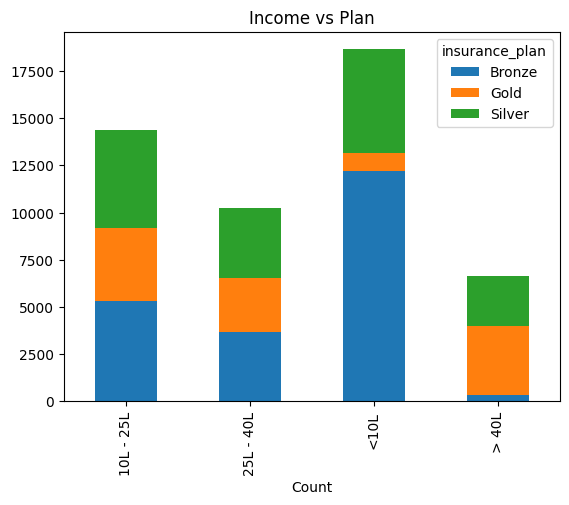

In [31]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked = True)
plt.title('Income vs Plan')
plt.xlabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

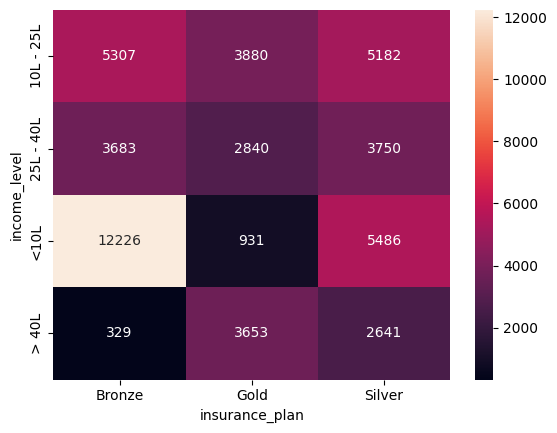

In [32]:
sns.heatmap(crosstab, annot=True, fmt='d')

### Feature Engineering

In [33]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [34]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [35]:
risk_score = {
    'diabetes':6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none':0
}

In [36]:
df2[['disease1','disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.sample()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
6703,18,Female,Northwest,Unmarried,1,Normal,No Smoking,Freelancer,25L - 40L,40,No Disease,Bronze,9479,no disease,None


In [37]:
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_score)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df2['normalized_risk_score'] = scaler.fit_transform(df2[['total_risk_score']])
df2.sample(6)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
11592,54,Female,Southwest,Unmarried,0,Overweight,No Smoking,Freelancer,> 40L,62,No Disease,Gold,26926,no disease,none,0,0.000000
1320,20,Female,Southwest,Unmarried,0,Underweight,Regular,Self-Employed,25L - 40L,29,No Disease,Silver,10510,no disease,none,0,0.000000
35635,20,Male,Northwest,Unmarried,2,Obesity,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,4397,no disease,none,0,0.000000
4344,30,Male,Southeast,Married,2,Normal,Regular,Salaried,25L - 40L,29,Diabetes,Silver,18205,diabetes,none,6,0.428571
36925,24,Male,Northeast,Unmarried,0,Underweight,No Smoking,Salaried,10L - 25L,25,No Disease,Bronze,9129,no disease,none,0,0.000000
768,19,Male,Northwest,Unmarried,1,Normal,No Smoking,Freelancer,> 40L,51,No Disease,Silver,8147,no disease,none,0,0.000000


In [38]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [39]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1,'Silver':2,'Gold':3})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [40]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [41]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [42]:
df4 = df3.drop(columns =['disease1','disease2', 'total_risk_score', 'medical_history'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


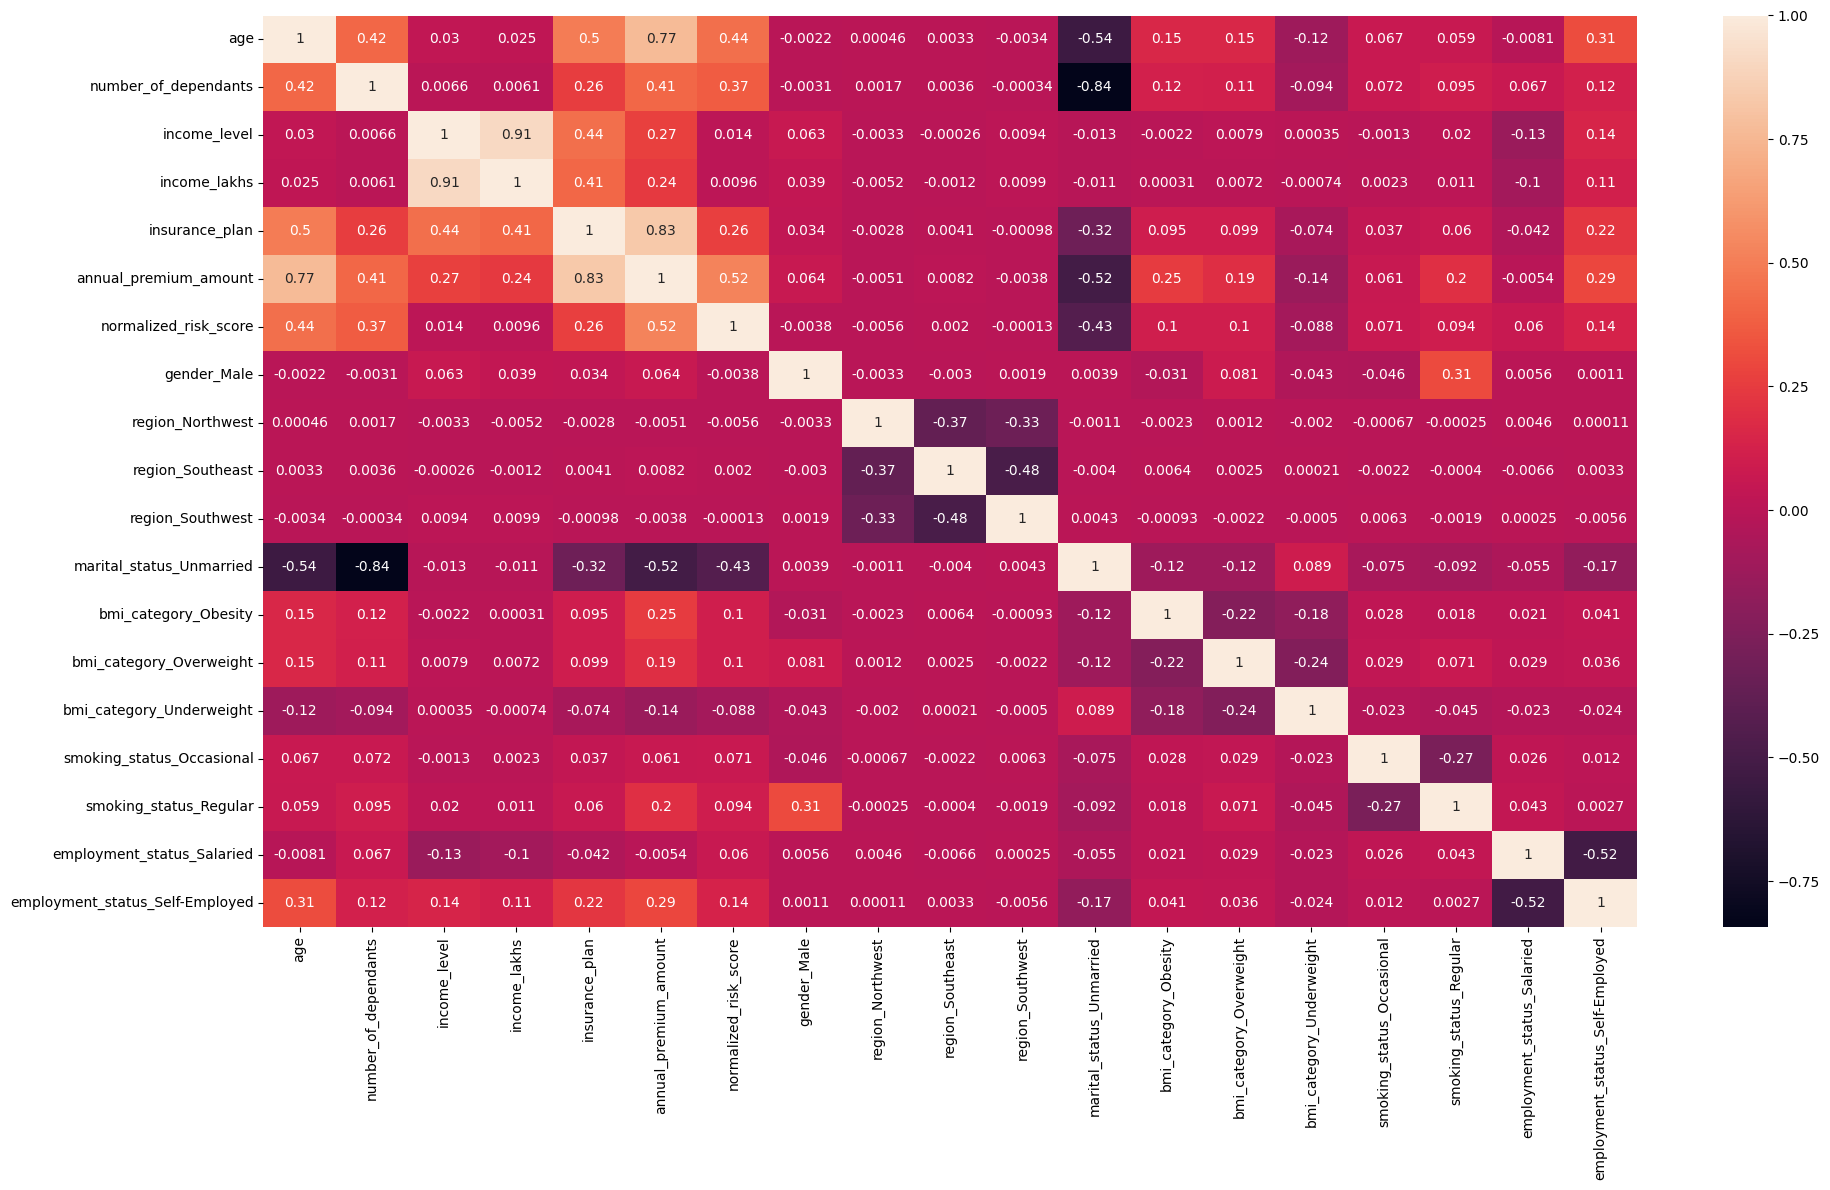

In [43]:
cm = df4.corr()

plt.figure(figsize = (20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation = 90)
plt.yticks = 0
plt.tight_layout()
plt.show()

In [44]:
x = df4.drop(columns = ['annual_premium_amount'])
y = df4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants','income_level', 'income_lakhs', 'insurance_plan']
x[cols_to_scale] = scaler.fit_transform(x[cols_to_scale])
x.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [46]:
calculate_vif(x)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [47]:
calculate_vif(x.drop(columns=['income_level']))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [48]:
X_reduced = x.drop(columns=['income_level'])
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Model Training

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

In [50]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9280957176093705, 0.9283765993531427)

In [54]:
y_pred = model_lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('Mean Squared Error :', mse)
print('R2 :', r2)
print('RMSE :', rmse)

Mean Squared Error : 5056639.130347776
R2 : 0.9283765993531427
RMSE : 2248.6972073509087


In [55]:
model_lr.intercept_

np.float64(4701.4380539658)

In [56]:
model_lr.coef_

array([11236.4082633 ,  -536.61172956,  -353.97067084, 12515.43782972,
        4846.88626348,   121.53023031,   -34.50219135,    27.97504587,
         -23.47372614,  -821.78088646,  3356.07750448,  1613.1421694 ,
         364.31350886,   722.41051531,  2261.97816483,   149.57179545,
         378.25130285])

In [57]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

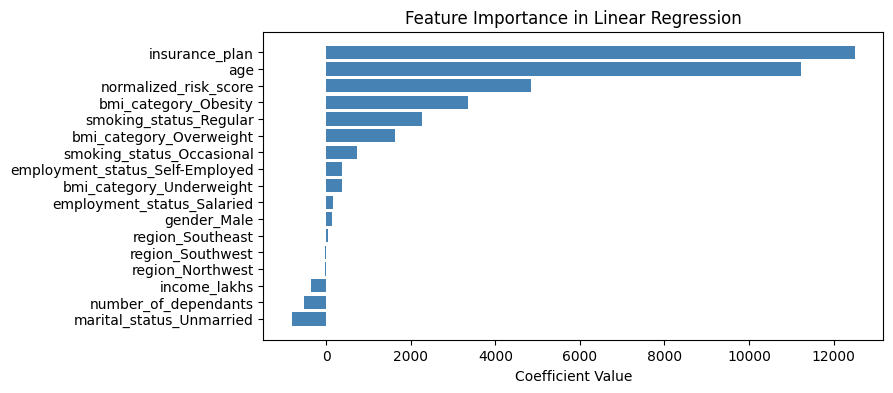

In [58]:
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [59]:
model_ridge = Ridge(alpha=20)
model_ridge.fit(X_train, y_train)
test_score = model_ridge.score(X_test, y_test)
train_score = model_ridge.score(X_train, y_train)
train_score, test_score

(0.9280809289466383, 0.9283604859538304)

In [60]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score = model_xgb.score(X_train, y_train)
train_score, test_score

(0.9861041903495789, 0.9807721972465515)

In [61]:

y_pred = model_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('Mean Squared Error :', mse)
print('R2 :', r2)
print('RMSE :', rmse)

Mean Squared Error : 1357488.75
R2 : 0.9807721972465515
RMSE : 1165.1131591796875


In [62]:
param_grid = {
    'n_estimators': [20,40,60],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3,4,5]
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter = 10, cv = 4, scoring='r2')
random_search.fit(X_train, y_train)
random_search.best_score_
random_search.best_params_

{'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.2}

In [63]:
best_model = random_search.best_estimator_

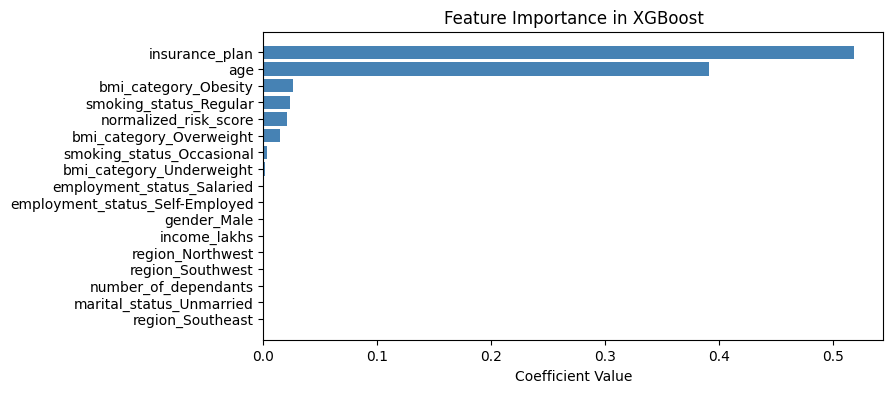

In [65]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [66]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals*100)/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predictes': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predictes,diff,diff_pct
24098,9246,9228.755859,-17.244141,-0.186504
201,11664,13557.285156,1893.285156,16.231869
25471,10472,7394.351562,-3077.648438,-29.389309
32500,26267,25813.269531,-453.730469,-1.727378
30832,9106,9228.755859,122.755859,1.348077


<Axes: xlabel='diff_pct', ylabel='Count'>

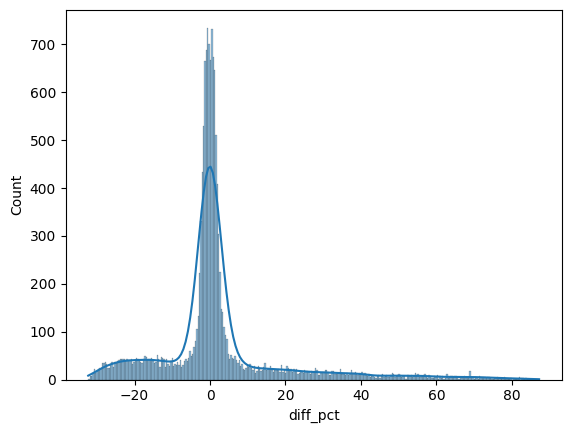

In [67]:
sns.histplot(results_df['diff_pct'], kde=True)

In [70]:
extreme_results_df = results_df[np.abs(results_df.diff_pct) > 10]
extreme_results_df.shape

(4369, 4)

In [72]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.1791892072397

#### Almost 30% of our predictions are extreme errors

In [73]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predictes,diff,diff_pct
10288,3517,6584.795898,3067.795898,87.227634
29904,3503,6536.672363,3033.672363,86.602123
25207,3501,6531.916504,3030.916504,86.572879
23975,3520,6554.833008,3034.833008,86.216847
48801,3516,6526.065430,3010.065430,85.610507
...,...,...,...,...
14376,4887,7340.228516,2453.228516,50.199069
38170,5026,7547.402832,2521.402832,50.167187
23574,4330,6499.593750,2169.593750,50.106091
6414,4322,6486.877441,2164.877441,50.089714


In [75]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
201,0.129630,0.2,0.636364,1.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0
25471,0.074074,0.0,0.010101,0.0,0.0,1,1,0,0,1,0,1,0,0,1,1,0
47939,0.111111,0.0,0.424242,1.0,0.0,0,1,0,0,1,0,0,1,0,0,1,0
26239,0.037037,0.0,0.292929,0.0,0.0,1,1,0,0,1,0,0,1,0,0,0,0
16907,0.111111,0.0,0.606061,0.5,0.0,1,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41535,0.129630,0.4,0.505051,0.5,0.0,0,1,0,0,1,0,1,0,1,0,0,0
21893,0.129630,0.4,0.242424,0.0,0.0,1,0,1,0,1,1,0,0,0,1,0,0
37321,0.018519,0.4,0.171717,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0
43822,0.111111,0.2,0.020202,0.0,0.0,0,0,1,0,1,1,0,0,0,0,0,0


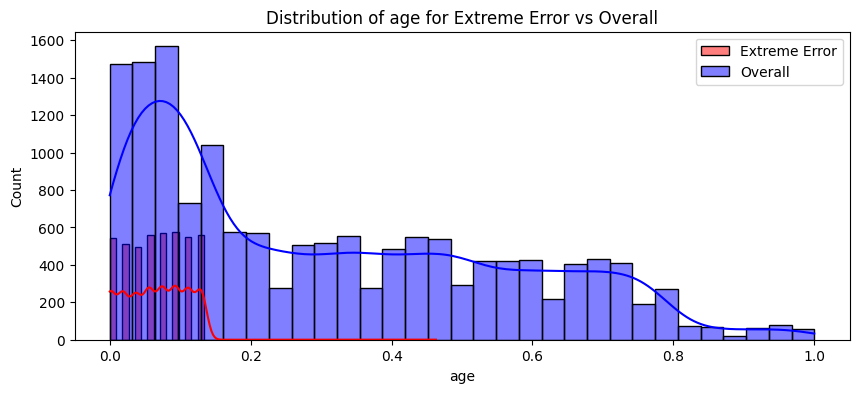

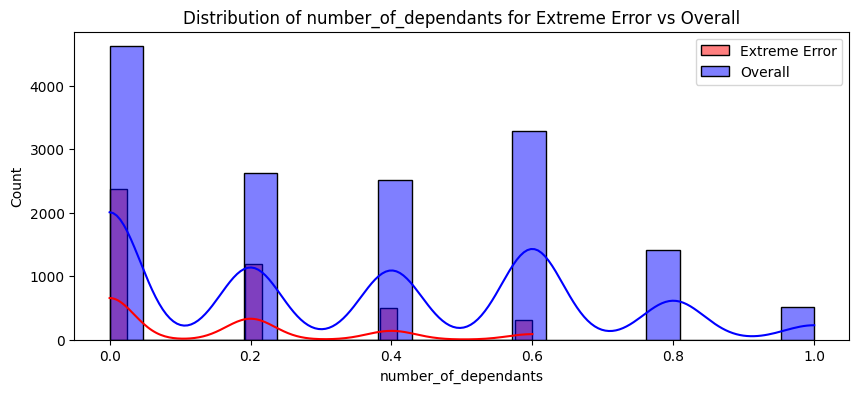

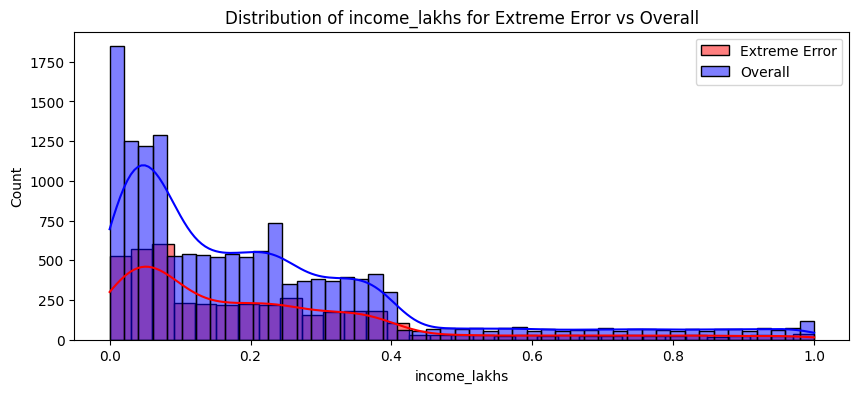

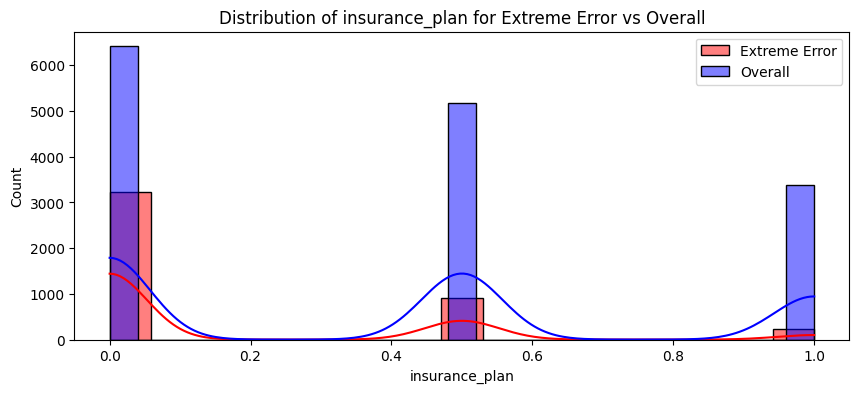

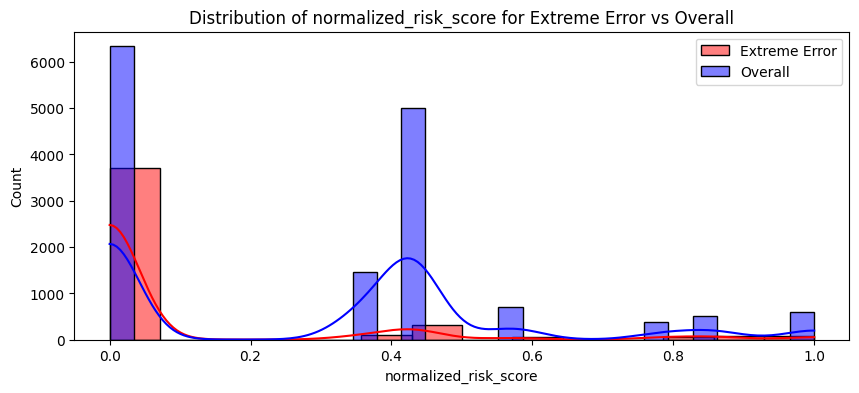

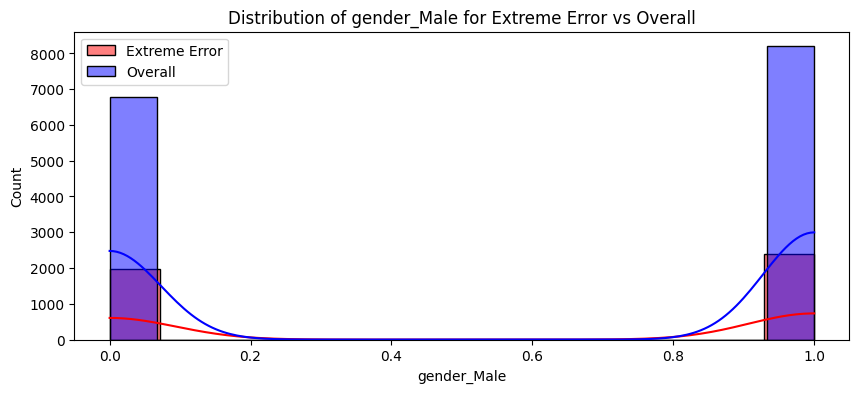

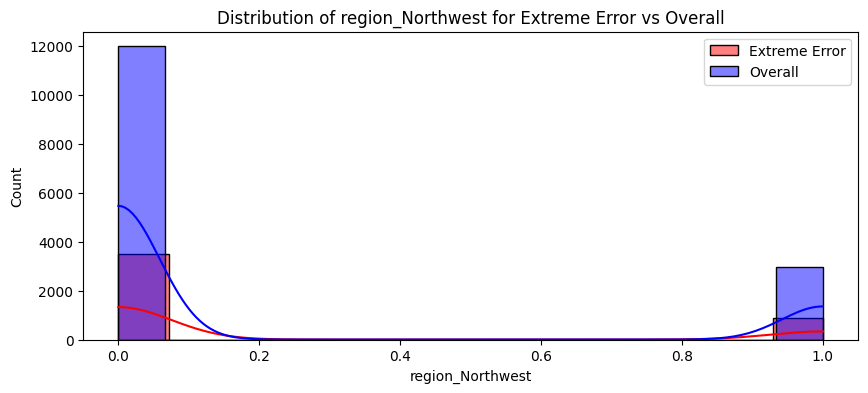

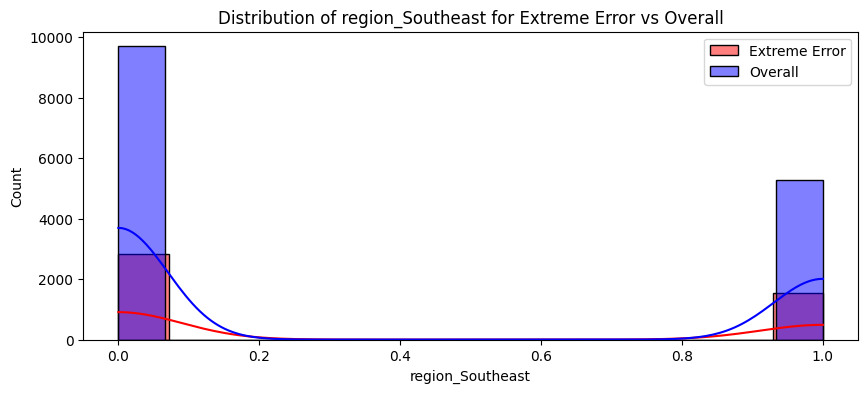

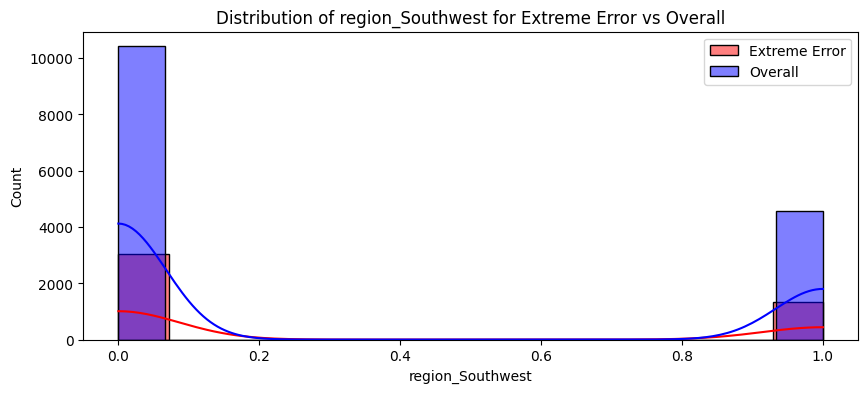

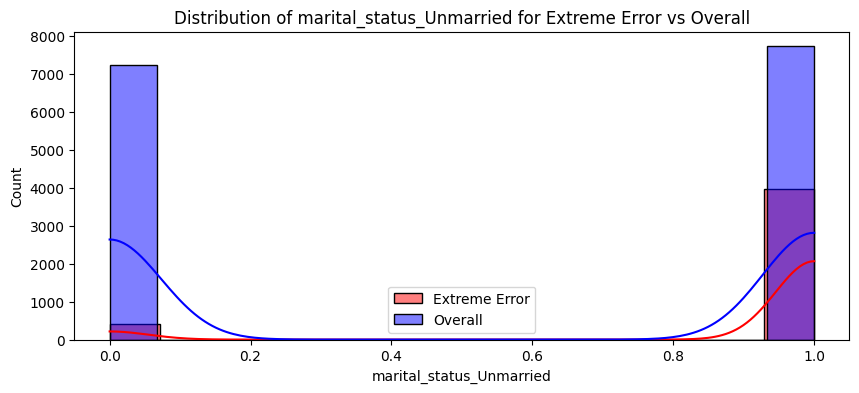

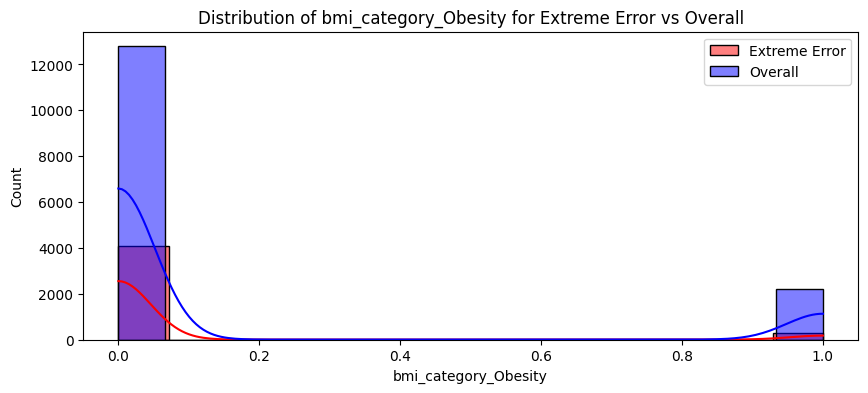

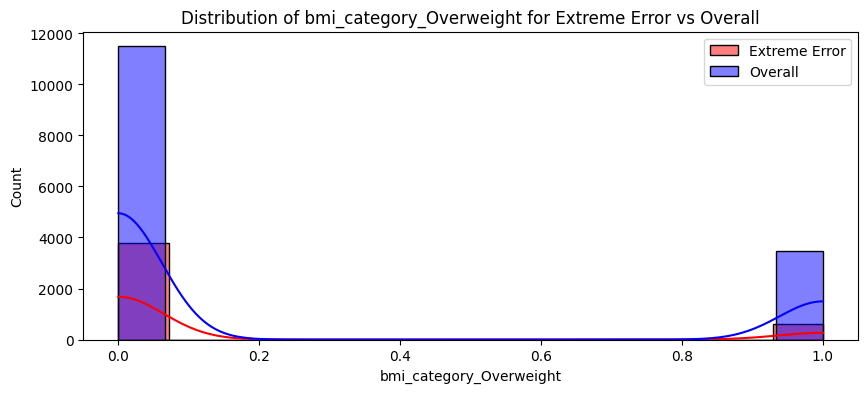

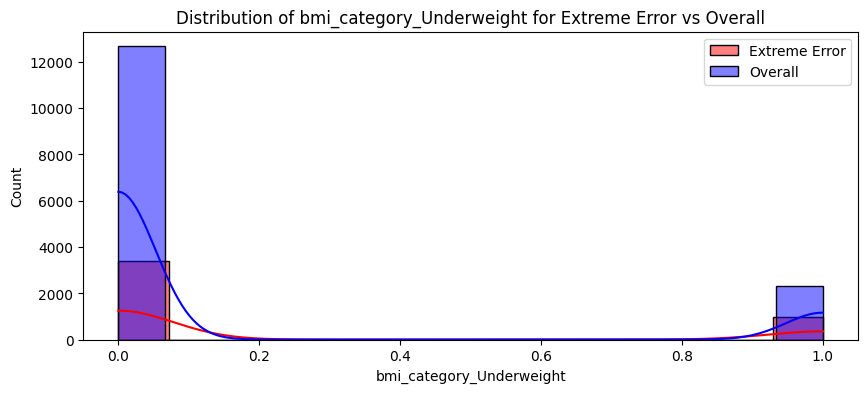

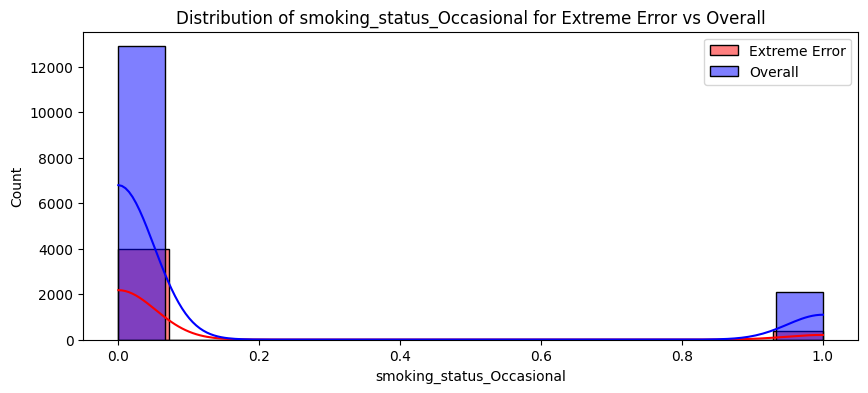

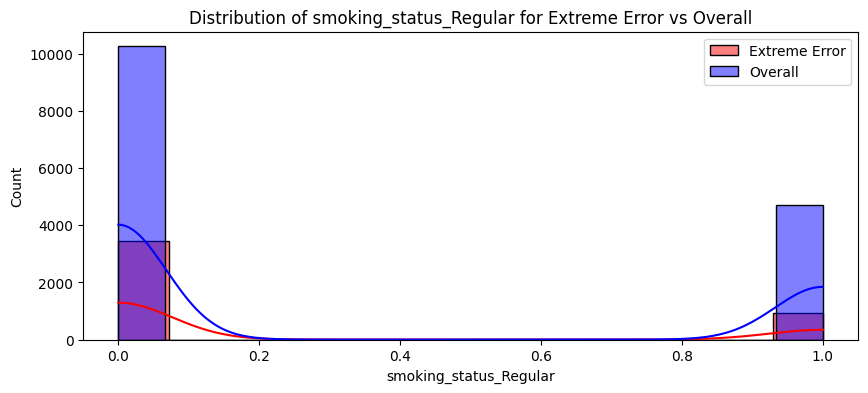

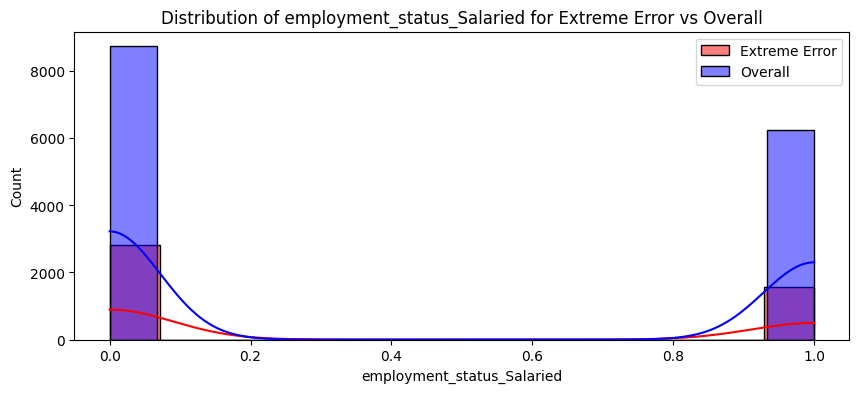

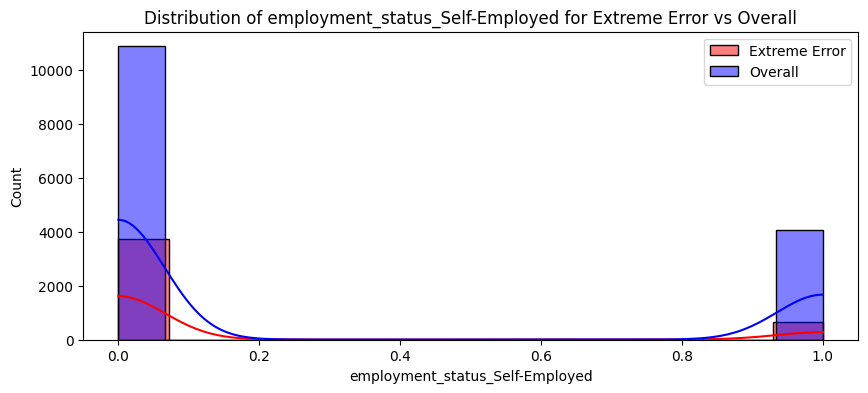

In [77]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Error', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Error vs Overall')
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

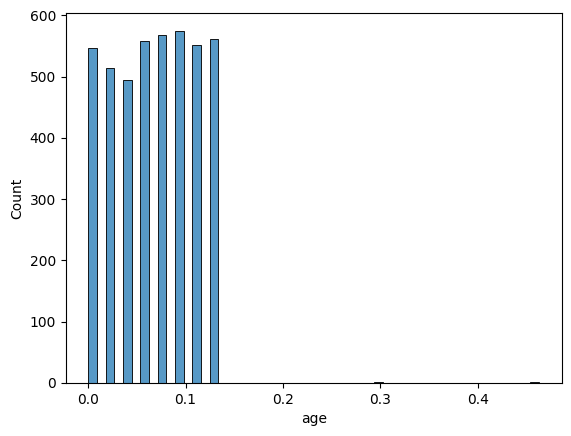

In [79]:
sns.histplot(extreme_errors_df.age) #Age group has so much of erros

In [80]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [81]:
extreme_errors_df['income_level'] = -1 # we removed it when vif , so causally putting to find the reversed data frame

In [83]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,25.0,1.0,-2.0,64.0,3.0
1,22.0,0.0,-2.0,2.0,1.0
2,24.0,0.0,-2.0,43.0,3.0
3,20.0,0.0,-2.0,30.0,1.0
4,24.0,0.0,-2.0,61.0,2.0
...,...,...,...,...,...
4364,25.0,2.0,-2.0,51.0,2.0
4365,25.0,2.0,-2.0,25.0,1.0
4366,19.0,2.0,-2.0,18.0,1.0
4367,24.0,1.0,-2.0,3.0,1.0


<Axes: xlabel='age', ylabel='Count'>

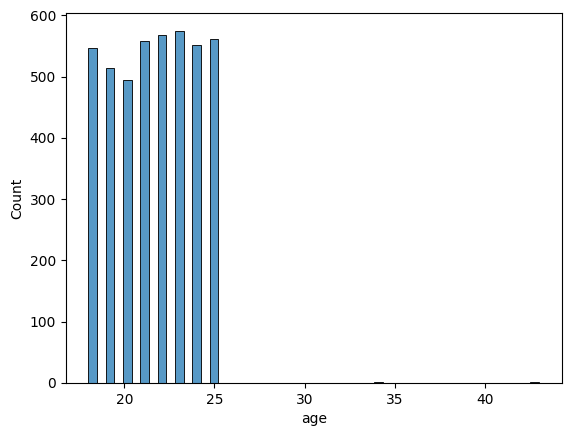

In [84]:
sns.histplot(df_reversed.age)

In [86]:
df_reversed['age'].quantile(0.97) #97% of the extreme error records have the age less than 25

np.float64(25.0)